In [1]:
import sys
sys.path.append(r"/mnt/ceph/users/tudomlumleart/00_VirtualEnvironments/teeu/lib/python3.10/site-packages")
sys.path.append(r"/mnt/home/tudomlumleart/.local/lib/python3.10/site-packages/")
sys.path.append(r"/mnt/home/tudomlumleart/ceph/00_VirtualEnvironments/jupyter-gpu/lib/python3.10/site-packages")
from utils import *
from functions import *
from sklearn.mixture import BayesianGaussianMixture
import sklearn
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import validation_curve

from sklearn.metrics import adjusted_mutual_info_score

import os
import scipy.io

import fancyimpute

2024-08-29 00:41:46.487083: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-29 00:41:46.927065: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512F AVX512_VNNI, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Load the data from the dataset 
dataset_dir = '/mnt/home/tudomlumleart/ceph/03_GaussianChainSimulation/20240627/dataset_100_10_20_10_1000_40.0_10000.pkl'

dataset_list, param_dict = load_dataset(dataset_dir)

template_list = dataset_list[0]['template_chain_list']
X = dataset_list[0]['observation_list']
label_list = dataset_list[0]['labels']

observations_flatten = [squareform(pdist(x)).flatten() for x in X]

# generate weight of each label from label_list
true_weights = np.array([np.sum(label_list == i) for i in np.unique(label_list)]) / len(label_list)
templates_flatten = [squareform(pdist(x)).flatten() for x in template_list]

# Generate random walk for guessing structures
num_monomers = param_dict['num_monomers']
mean_bond_length = param_dict['mean_bond_length']
std_bond_length = param_dict['std_bond_length'] 
num_templates = param_dict['num_templates']
measurement_error = param_dict['noise_std']
num_observations = param_dict['num_observations']
num_probes = num_monomers
num_candidates = num_templates


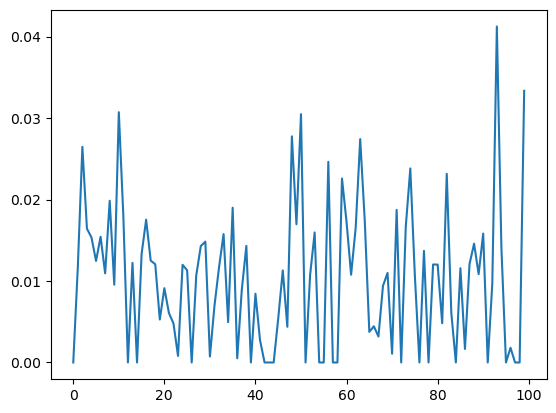

In [21]:
# Introducing missing data to the dataset at specific barcodes with some probabiliity between [0, 1]
missing_data_prob = np.random.normal(0.01, 0.01, num_monomers)
missing_data_prob[missing_data_prob < 0] = 0
missing_data_prob[missing_data_prob > 1] = 1
plt.plot(missing_data_prob)

In [15]:
def interpolate_polymers(polys):
    num_probes, num_coords, num_cells = polys.shape
    new_polys = np.zeros((num_probes, num_coords, num_cells))
    for c in range(num_cells):
        curr_cells = polys[:, :, c]
        for x in range(num_coords):
            curr_coords = curr_cells[:, x]
            missing_indices = np.isnan(curr_coords)
            valid_indices = ~missing_indices
            interp_coords = np.interp(np.flatnonzero(missing_indices), np.flatnonzero(valid_indices), curr_coords[valid_indices])
            new_polys[missing_indices, x, c] = interp_coords
            new_polys[valid_indices, x, c] = curr_coords[valid_indices]
    return new_polys

In [22]:
# Get shuffle indices for shuffling dataset 
shuffle_indices = np.arange(num_observations)
np.random.shuffle(shuffle_indices)

observations_with_nan = np.array([squareform(pdist(x)) for x in X])
observations_with_nan = observations_with_nan[shuffle_indices, :, :]
polys_with_nan = np.array([x for x in X])
polys_with_nan = polys_with_nan[shuffle_indices, :, :]
existing_data = np.zeros(observations_with_nan.shape)
# Randomly add nan to the dataset based on the missing_data_prob
for i in range(num_observations):
    missing_indices = np.random.uniform(size=num_monomers) < missing_data_prob
    observations_with_nan[i, missing_indices, :] = np.nan
    observations_with_nan[i, :, missing_indices] = np.nan
    polys_with_nan[i, missing_indices, :] = np.nan
    existing_data[i, ~missing_indices, :] = 1
    existing_data[i, :, ~missing_indices] = 1
    
existing_data_flatten = np.array([x.flatten() for x in existing_data.astype(bool)])
observations_flatten = np.array([squareform(pdist(x)) for x in X])[shuffle_indices, :, :]
observations_flatten = np.array([x.flatten() for x in observations_flatten])
observations_flatten_with_nan = np.array([x.flatten() for x in observations_with_nan])
mean_impute_polys = interpolate_polymers(polys_with_nan)
mean_impute_maps = [squareform(pdist(x)) for x in mean_impute_polys]

In [7]:
polys_with_nan.shape

(10000, 100, 3)

In [20]:
missing_data_prob

array([0.0934489 , 0.093938  , 0.07790302, 0.07817163, 0.07696745,
       0.08333416, 0.09278922, 0.09217112, 0.11630707, 0.09936567,
       0.0968635 , 0.09748691, 0.12100718, 0.09018752, 0.09734435,
       0.09619415, 0.10764002, 0.09133418, 0.10378497, 0.11006483,
       0.08763745, 0.08513883, 0.09299472, 0.08468063, 0.08381805,
       0.09651366, 0.09836784, 0.09247064, 0.09746037, 0.0925805 ,
       0.09490727, 0.12642911, 0.09269318, 0.0959809 , 0.10486911,
       0.09694   , 0.09045115, 0.09736901, 0.09579597, 0.09827554,
       0.07888192, 0.09728509, 0.1102948 , 0.11493948, 0.10188495,
       0.07055301, 0.10752569, 0.10074947, 0.10923488, 0.10997723,
       0.11249809, 0.08332386, 0.09285229, 0.09551985, 0.09709959,
       0.09090498, 0.09073211, 0.10001763, 0.10538944, 0.11266463,
       0.10675055, 0.09296824, 0.10474142, 0.0956057 , 0.08331459,
       0.11703541, 0.09659916, 0.10819963, 0.09352904, 0.1144967 ,
       0.0911748 , 0.09592519, 0.09349851, 0.10141914, 0.07836

In [19]:
np.random.uniform(size=num_monomers)

array([0.73716074, 0.82550355, 0.47976933, 0.78639316, 0.86871885,
       0.1878159 , 0.32242387, 0.94250804, 0.15773186, 0.75733087,
       0.25397979, 0.18355653, 0.98135257, 0.98836248, 0.56114239,
       0.15597359, 0.43447815, 0.94254409, 0.31513705, 0.97376283,
       0.01131976, 0.11003485, 0.33593898, 0.34006982, 0.3344335 ,
       0.93463886, 0.88316034, 0.10860756, 0.09590058, 0.89334964,
       0.56706856, 0.38174604, 0.03178973, 0.42218479, 0.97679085,
       0.19730776, 0.72266856, 0.56395306, 0.82615623, 0.2201612 ,
       0.72602609, 0.55411523, 0.15613098, 0.59370203, 0.11772046,
       0.03381251, 0.78231717, 0.28138745, 0.7994041 , 0.49092942,
       0.03657743, 0.49650126, 0.20825967, 0.244263  , 0.05710753,
       0.4802846 , 0.37435258, 0.58022164, 0.95126978, 0.2023388 ,
       0.2389141 , 0.98835928, 0.95744855, 0.21190096, 0.92012962,
       0.87993761, 0.24419428, 0.10991297, 0.44111864, 0.02223373,
       0.8263571 , 0.53775165, 0.99792025, 0.60889648, 0.10708

In [24]:
si = []
knn = []
iSVD = []

bc1_nan_map = observations_flatten_with_nan
bc1_map = observations_flatten

bc1_nan_map_normalized = fancyimpute.BiScaler().fit_transform(bc1_nan_map)
si.append(fancyimpute.SoftImpute().fit_transform(bc1_nan_map_normalized))
knn.append(fancyimpute.KNN().fit_transform(bc1_nan_map))
iSVD.append(fancyimpute.IterativeSVD().fit_transform(bc1_nan_map))
    
si = np.hstack(si)
knn = np.hstack(knn)
iSVD = np.hstack(iSVD)

[BiScaler] Initial log residual value = 23.028425
[BiScaler] Iter 1: log residual = 8.933574, log improvement ratio=14.094851
[BiScaler] Iter 2: log residual = 4.990797, log improvement ratio=3.942777
[BiScaler] Iter 3: log residual = 1.714131, log improvement ratio=3.276666
[BiScaler] Iter 4: log residual = -0.869071, log improvement ratio=2.583202
[BiScaler] Iter 5: log residual = -3.320873, log improvement ratio=2.451802
[BiScaler] Iter 6: log residual = -5.760424, log improvement ratio=2.439551
[BiScaler] Iter 7: log residual = -8.200574, log improvement ratio=2.440150
[BiScaler] Iter 8: log residual = -10.642672, log improvement ratio=2.442098
[BiScaler] Iter 9: log residual = -13.086875, log improvement ratio=2.444203
[BiScaler] Iter 10: log residual = -15.533124, log improvement ratio=2.446249
[BiScaler] Iter 11: log residual = -17.981288, log improvement ratio=2.448165
[BiScaler] Iter 12: log residual = -20.431210, log improvement ratio=2.449922
[BiScaler] Iter 13: log residual

In [60]:
si = []

for k in tqdm(range(num_probes)):
    bc1_nan_map = observations_flatten_with_nan[:, num_probes*k:num_probes*(k+1)]
    bc1_map = observations_flatten[:, num_probes*k:num_probes*(k+1)]
    
    si.append(fancyimpute.SoftImpute().fit_transform(bc1_nan_map))
    
si = np.hstack(si)

/mnt/sw/nix/store/gpkc8q6zjnp3n3h3w9hbmbj6gjbxs85w-python-3.10.10-view/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:469: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/mnt/sw/nix/store/gpkc8q6zjnp3n3h3w9hbmbj6gjbxs85w-python-3.10.10-view/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:469: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/mnt/sw/nix/store/gpkc8q6zjnp3n3h3w9hbmbj6gjbxs85w-python-3.10.10-view/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:469: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.

  0%|          | 0/100 [00:00<?, ?it/s]

[SoftImpute] Max Singular Value of X_init = 935345.916424
[SoftImpute] Iter 1: observed MAE=79.111439 rank=52
[SoftImpute] Iter 2: observed MAE=71.645164 rank=31
[SoftImpute] Iter 3: observed MAE=64.505067 rank=20
[SoftImpute] Iter 4: observed MAE=58.693423 rank=10
[SoftImpute] Iter 5: observed MAE=54.998742 rank=8
[SoftImpute] Iter 6: observed MAE=52.901233 rank=5
[SoftImpute] Iter 7: observed MAE=52.065380 rank=5
[SoftImpute] Iter 8: observed MAE=51.827447 rank=5
[SoftImpute] Iter 9: observed MAE=51.470614 rank=4
[SoftImpute] Iter 10: observed MAE=50.789912 rank=3
[SoftImpute] Iter 11: observed MAE=50.350144 rank=3
[SoftImpute] Iter 12: observed MAE=49.883172 rank=2
[SoftImpute] Iter 13: observed MAE=49.606529 rank=2
[SoftImpute] Iter 14: observed MAE=49.453370 rank=2
[SoftImpute] Iter 15: observed MAE=49.368000 rank=2
[SoftImpute] Iter 16: observed MAE=49.320016 rank=2
[SoftImpute] Iter 17: observed MAE=49.292597 rank=2
[SoftImpute] Iter 18: observed MAE=49.276726 rank=2
[SoftImpute

In [27]:
error_softImpute = np.linalg.norm(si- observations_flatten)
print(error_softImpute)

7748322.639189083


In [28]:
error_knn = np.linalg.norm(knn- observations_flatten)
print(error_knn)

78425.73924938354


In [29]:
error_iSVD = np.linalg.norm(iSVD - observations_flatten)
print(error_iSVD)

78357.40561735256


In [25]:
mean_impute_flatten = [x.flatten() for x in mean_impute_maps]

In [26]:
error_meanImpute = np.linalg.norm(mean_impute_flatten - observations_flatten)
print(error_meanImpute)

274839.557585683


In [30]:
iSVD_allMaps = [x.reshape(100, 100) for x in iSVD]
si_allMaps = [x.reshape(100, 100) for x in si]
knn_allMaps = [x.reshape(100, 100) for x in knn]
mean_impute_allMaps = [x.reshape(100, 100) for x in mean_impute_flatten]

In [32]:
iSVD_median_map = np.median(iSVD_allMaps, axis=0)
si_median_map = np.median(si_allMaps, axis=0)
knn_median_map = np.median(knn_allMaps, axis=0)
mean_impute_median_map = np.median(mean_impute_allMaps, axis=0)
true_median_map = np.median([x.reshape(100, 100) for x in observations_flatten], axis=0)

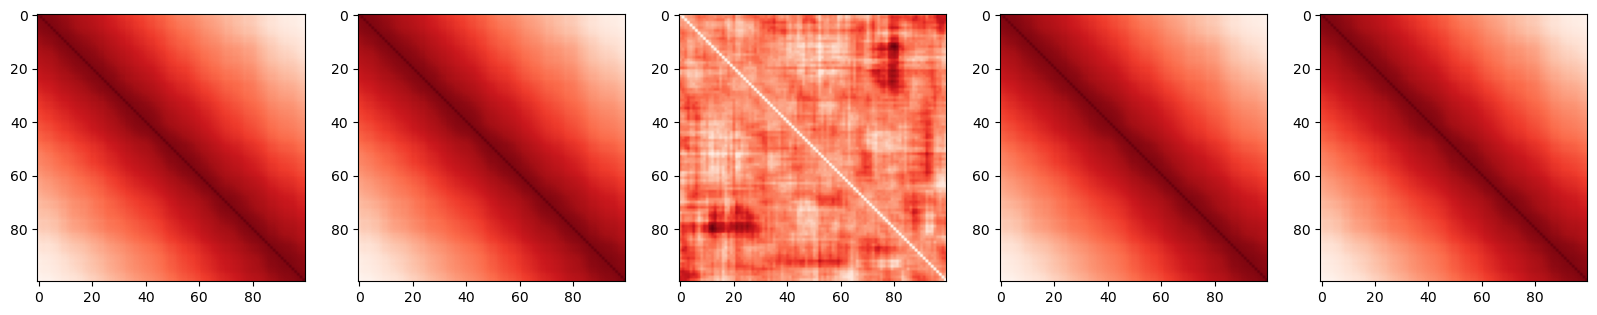

In [33]:
# Plot these maps in a plot with 5 subplots
fig, ax = plt.subplots(1, 5, figsize=(20, 5))
ax[0].imshow(true_median_map, cmap='Reds_r')
ax[1].imshow(iSVD_median_map, cmap='Reds_r')
ax[2].imshow(si_median_map, cmap='Reds_r')
ax[3].imshow(knn_median_map, cmap='Reds_r')
ax[4].imshow(mean_impute_median_map, cmap='Reds_r')
